# 版权声明

版权 © 2023 斯坦福大厨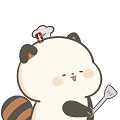，华中科技大学微纳材料设计与制造研究中心的科研工作者。

恭喜您已经发现了这份神奇的计算材料学课件！这份课件是我在熬夜吃掉不计其数的披萨和咖啡后创作出来的，配套的教材是由单斌、陈征征、陈蓉合著的《计算材料学-从算法原理到代码实现》。学习资料合集您可以在这个网址找到：[www.materialssimulation.com/book](www.materialssimulation.com/book)。希望它能帮您在计算材料学的道路上摔得不那么痛。

就像您尊重那些一边烘焙披萨一边写代码的大厨一样，当您使用这份课件时，请：

- 记得告诉大家这份课件是斯坦福大厨写的，并且他在华中科技大学微纳中心工作
- 别用它去赚大钱，这个课件是用来学习的，不是用来买披萨的
- 保持开放共享的精神

如果你有关于计算材料学的想法，或者你只是想和我讨论最好吃的披萨口味，欢迎通过邮件 bshan@mail.hust.edu.cn 联系我。
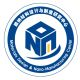

## 1. 一维谐振子运动方程

在这个notebook里，我们将用verlet算法对于一维谐振子的运动进行积分。由于一维谐振子有解析解，所以我们可以将数值积分的结果与解析形式相比对，从而对误差积累，算法稳定性等有一个直观的认识。一维谐振子的解析解如下：

1. 位置:

   $x(t) = x_0 \cos(wt) + \frac{v_0}{w} \sin(wt)$

2. 速度:

   $v(t) = -x_0 w \sin(wt) + v_0 \cos(wt)$

where, 
$w = \sqrt{\frac{k}{m}}$


我们首先定义一个HarmonicOscillator的类，用于描述谐振子：

In [ ]:
import numpy as np

class HarmonicOscillator:
    def __init__(self, k, m):
        self.k = k
        self.m = m

    def acceleration(self, x):
        return -self.k * x / self.m

    def analytical_solution(self, x0, v0, t):
        """
        Calculate the analytical solution for the 1D harmonic oscillator.

        Parameters:
        x0 : float
            Initial position.
        v0 : float
            Initial velocity.
        t : float
            Time at which to calculate the position and velocity.

        Returns:
        x : float
            Position at time t.
        v : float
            Velocity at time t.
        """
        w = np.sqrt(self.k / self.m)  # angular frequency
        x = x0 * np.cos(w*t) + v0/w * np.sin(w*t)
        v = -x0 * w * np.sin(w*t) + v0 * np.cos(w*t)
        return x, v


我们可以用这样的方法来创建一个HarmonicOscillator实例，它的acceleration函数会告诉你谐振子处在位置x处的加速度

In [ ]:
# Set up the system
k = 1.0  # spring constant
m = 1.0  # mass
oscillator = HarmonicOscillator(k, m)
oscillator.acceleration(1.0)

-1.0

## 2. 前向Euler算法

前向Euler积分算法是一种简单的初值问题数值解法，通常用于常微分方程的数值模拟。该方法的主要思想是使用泰勒级数将微分方程展开，然后用前向差分来近似导数，从而推进时间步。

前向Euler方法是一种显式方法，它根据当前状态（即在第n个时间步）的信息来预测下一个状态（即在第n+1个时间步）。具体地，对于一个常微分方程dy/dt = f(y, t)，前向Euler方法更新y的方式如下：

y(n+1) = y(n) + dt * f(y(n), t(n))

其中，y(n)是在第n个时间步的解，dt是时间步长，f(y, t)是微分方程的右侧函数。

前向Euler方法的一个主要优点是其简单性：只需要当前状态就可以预测下一个状态。然而，它也有一些缺点：尽管它是一阶精确的（即随着时间步长的减小，误差按线性规模减小），但是对于长时间的模拟或对精度要求高的模拟，前向Euler方法可能会带来较大的误差。此外，它也不是辛普莱克的，因此可能无法很好地保守物理系统的能量。

在使用前向Euler方法时，需要根据问题的具体需求来适当选择时间步长，并在必要时考虑使用更高阶的数值积分方法。

In [ ]:
class ForwardEulerIntegrator:
    """
    A numerical integrator using the Forward Euler method.
    """

    def __init__(self, dt):
        """
        Initialize the integrator.

        Parameters:
        dt : float
            Time step for the numerical integration.
        """
        self.dt = dt

    def step(self, system, x, v):
        """
        Perform one integration step.

        Parameters:
        system : object
            The physical system to be integrated. It should have a method `acceleration(x)` that computes the acceleration.
        x : float
            Current position.
        v : float
            Current velocity.

        Returns:
        float, float
            Updated position and velocity.
        """
        a = system.acceleration(x)
        x_new = x + self.dt * v
        v_new = v + self.dt * a

        return x_new, v_new


## 3. 一维谐振子的前向Euler积分求解

In [ ]:
import matplotlib.pyplot as plt

def plot_results(times, positions, velocities):
    """
    Plot the time evolution of position and phase space trajectory.
    
    This function generates two subplots: one showing the position as a function
    of time, and one showing the phase space trajectory (velocity vs. position).
    
    Parameters:
    times : list of float
        List of times at which the position and velocity were recorded.
    positions : list of float
        List of positions of the harmonic oscillator at the corresponding times.
    velocities : list of float
        List of velocities of the harmonic oscillator at the corresponding times.
    
    Returns:
    None
    """

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    ax1.plot(times, positions)
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Position')
    ax1.set_title('Time Evolution of Position')

    ax2.plot(positions, velocities)
    ax2.set_xlabel('Position')
    ax2.set_ylabel('Velocity')
    ax2.set_title('Phase Space Trajectory')

    plt.tight_layout()
    plt.show()


我们可以用前向Euler积分器进行一维谐振子的求解。

可以很明显地看到，前向Euler方法可能导致所模拟系统的能量逐渐增加，这是因为在每一步积分中，由于一阶近似的误差，系统的动能和势能可能都会被高估。这就像在每一步都向系统“注入”了一点额外的能量。这种现象在数值模拟领域常被称为"过热"。

这也是为什么在需要长时间模拟，或者对模拟精度要求较高的场合，通常会使用更高阶，或者保守能量的积分方法，例如Verlet积分等满足Symplectic条件的方法，而不是前向Euler方法。

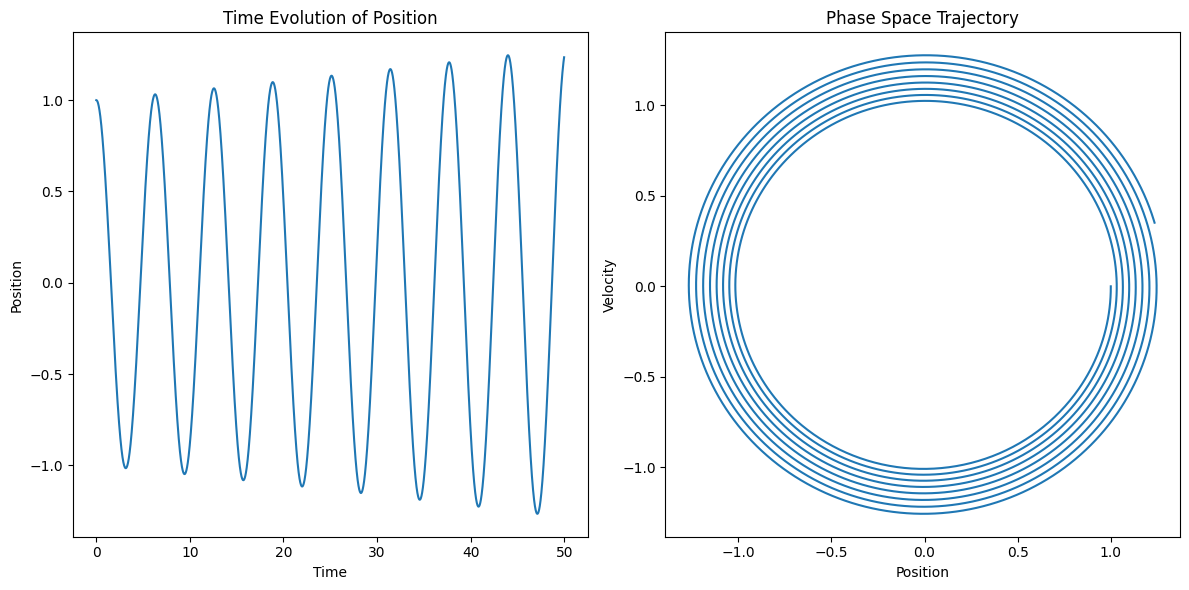

In [ ]:
import math

def main():
    # Set up the system
    k = 1.0  # spring constant
    m = 1.0  # mass
    oscillator = HarmonicOscillator(k, m)

    # Set up the integrator
    dt = 0.01  # time step
    integrator = ForwardEulerIntegrator(dt)

    # Initial conditions
    x = 1.0  # initial position
    v = 0.0  # initial velocity

    # Lists to store time, positions, and velocities
    times = []
    positions = []
    velocities = []

    # Time evolution
    for i in range(5000):
        times.append(i * dt)
        positions.append(x)
        velocities.append(v)
        x, v = integrator.step(oscillator, x, v)
        

    plot_results(times, positions, velocities)

if __name__ == "__main__":
    main()